# Cancer Detection and UNet
---

In this lab, we will learn on a dataset for a real-world task. We will be performing cancer detection: given a photo of a slide of cells, identify the areas of cancerous cells. We will be performing image segmentation: classifying each pixel as cancerous or non-cancerous.

You will create a large network, using the U-net architecture described below. The main goal of this lab is for you to understand how to create complex network architectures capable of learning difficult tasks.

---
## Grading Criteria
* 20% Completed dataset analysis
* 20% Correct training and validation functions
* 10% Proper creation, training, and validation of smallest-possible network for this task
* 40% Proper creation, training, and validation of the U-net architecture
* 10% Reasonable validation results achieved with the U-net architecture
---

In [1]:
import os
import gzip
import tarfile
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils, datasets

Set the global variable `device = torch.device("cpu")`. You can change this to `cuda` once you know everything is working, that way you don't run out of your GPU resources on Colab.

Remember to use a CPU runtime when not using the GPU. Colab has strict limits on how long you can use a GPU runtime.

In [2]:
device = torch.device("cuda") # Ran out of GPU time on Colab

WARNING: You may run into an error that says `RuntimeError: CUDA out of memory.`

If you get this error immediately when training, then your batch is probably larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime.
If you get this error after training for multiple steps then you probably are not freeing up computation graph, i.e. you are storing `loss` instead of `loss.item()`.

In [3]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))

    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)

  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]

  def __len__(self):
    return len(self.dataset_folder)

---

# Part 1: Analyzing the Dataset

First things first.
Let's take a look at the dataset.

*Note: This may take a while to download; it may be quicker to upload it to Colab from your machine.*

In [4]:
train_dataset = CancerDataset("/tmp/Datasets/cancer", train=True)
val_dataset = CancerDataset("/tmp/Datasets/cancer", train=False)

100%|██████████| 2750494655/2750494655 [00:54<00:00, 50554256.39it/s]


Extracting /tmp/Datasets/cancer/cancer_data.tar.gz
Untarring /tmp/Datasets/cancer/cancer_data.tar


Print out the lengths of your train and validation datasets, so you know how much data you are working with.

In [5]:
print(f"Length of training dataset: {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")

Length of training dataset: 1342
Length of validation dataset: 175


Now you should examine a single data instance from the dataset.
We'll use pos_test_000072.png (`val_dataset[172]`) as an example throughout training.
Collect the image and the cancer labels from pos_test_000072.png (i.e. `val_x, val_y = val_dataset[172]`).

Image (val_x): tensor([[[0.9098, 0.9373, 0.9569,  ..., 0.9412, 0.9451, 0.9412],
         [0.9412, 0.9569, 0.9647,  ..., 0.9490, 0.9490, 0.9490],
         [0.9569, 0.9608, 0.9569,  ..., 0.9333, 0.9569, 0.9569],
         ...,
         [0.8784, 0.8863, 0.9451,  ..., 0.9294, 0.9529, 0.9412],
         [0.8667, 0.9020, 0.9294,  ..., 0.9373, 0.9333, 0.9333],
         [0.9412, 0.9373, 0.9490,  ..., 0.9608, 0.9294, 0.9333]],

        [[0.9059, 0.9333, 0.9569,  ..., 0.9294, 0.9176, 0.9255],
         [0.9490, 0.9608, 0.9647,  ..., 0.9412, 0.9294, 0.9451],
         [0.9647, 0.9647, 0.9608,  ..., 0.9294, 0.9451, 0.9608],
         ...,
         [0.4431, 0.5882, 0.7294,  ..., 0.9255, 0.9333, 0.9373],
         [0.4196, 0.6078, 0.7765,  ..., 0.9333, 0.9216, 0.9176],
         [0.7922, 0.8431, 0.8510,  ..., 0.9333, 0.9216, 0.9176]],

        [[0.8863, 0.9137, 0.9529,  ..., 0.9176, 0.9255, 0.9294],
         [0.9451, 0.9529, 0.9647,  ..., 0.9137, 0.9216, 0.9294],
         [0.9490, 0.9569, 0.9529,  ..., 0.9

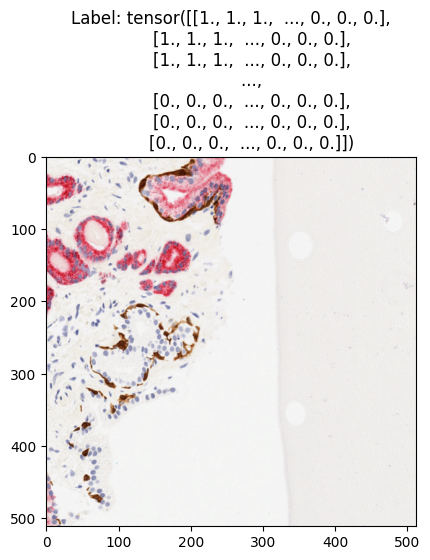

In [6]:
# Access the 172nd item in the validation dataset
val_x, val_y = val_dataset[172]

# Print out the image and label for inspection
print(f"Image (val_x): {val_x}")
print(f"Label (val_y): {val_y}")

plt.imshow(val_x.permute(1, 2, 0))
plt.title(f"Label: {val_y}")
plt.show()

Let's analyze the `x` data first. Print out the shape and dtype of `val_x` below.

In [7]:
print(f"Shape of val_x: {val_x.shape}")
print(f"Data type of val_x: {val_x.dtype}")

Shape of val_x: torch.Size([3, 512, 512])
Data type of val_x: torch.float32


`x` has 3 channels, which likely means that `x` is an RGB image (which it is).
Since RGB images can be values between [0, 255] or [0, 1] we should print out the min and max values of x to see which.
Print out the min and max values of x below.

In [8]:
print(f"Min value of val_x: {val_x.min().item()}")
print(f"Max value of val_x: {val_x.max().item()}")

Min value of val_x: 0.0235294122248888
Max value of val_x: 0.9764705896377563


The values are between [0, 1], which is good because that means we don't have do any normalization.

Now implement a `plot_image()` function which should plot an `x` variable.
You can use the `plt.imshow()` function to plot an RGB image.

Plot `val_x` and validate that it looks the same as the image file in "tmp/Datasets/cancer/cancer_data/cancer_data/inputs_test/0/pos_test_000072.png" in the dataset.

*Note: Per PyTorch convention an image has its channels at the 0th dimension (ignoring the batch dimension), but matplotlib expects the channel dimension at the 2nd dimension. You will need to permute the dimensions the plot it correctly*.

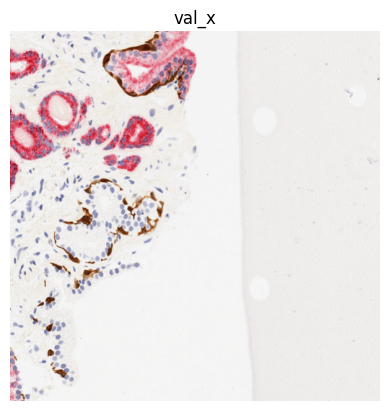

In [9]:
def plot_image(x):
    # Rearrange the dimensions from (C, H, W) to (H, W, C)
    img = x.permute(1, 2, 0)

    # Plot the image using matplotlib
    plt.imshow(img)
    plt.axis('off')
    plt.title('val_x')
    plt.show()

plot_image(val_x)

Now let's have a look at the cancer labels `y`; print out the shape and dtype of `val_y`.

In [10]:
print(f"Shape of val_y: {val_y.shape}")
print(f"Data type of val_y: {val_y.dtype}")

Shape of val_y: torch.Size([512, 512])
Data type of val_y: torch.float32


`y` has 1 channel (but it is squeezed so there is no channel dimension).
This most likely means that `y` is a grayscale image (which it is).

Implement `plot_cancer()` which should plot a `y` variable. You can use the `plt.imshow()` function to plot a grayscale image (pass in the `cmap="gray"` argument to make the image grayscale).

Plot `val_y` and validate that it looks like the label image "tmp/Datasets/cancer/cancer_data/cancer_data/outputs_test/0/pos_test_000072.png" in the dataset.

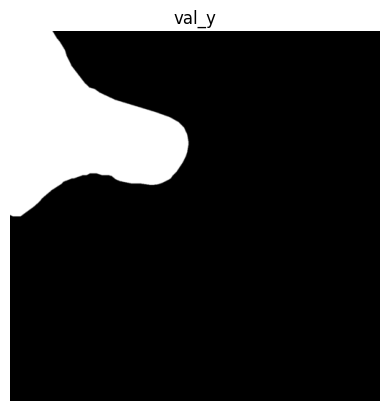

In [11]:
def plot_cancer(y):
    # Plot the grayscale image using matplotlib with the 'gray' colormap
    plt.imshow(y, cmap='gray')
    plt.axis('off')
    plt.title('val_y')
    plt.show()

plot_cancer(val_y)

The cancer is white which means that our cancerous label is 1 and our noncancerous label is 0.
Interestingly, the dtype of `y` is a float, but we were expecting cancer labels (i.e. cancerous vs noncancerous).
Use `torch.unique()` below to see all the unique values of `y`.

In [12]:
unique_values = torch.unique(val_y)
print(f"Unique values in val_y: {unique_values}")

Unique values in val_y: tensor([0.0000, 0.0157, 0.0627, 0.0706, 0.1098, 0.1255, 0.1569, 0.1725, 0.1804,
        0.2980, 0.3137, 0.3451, 0.3608, 0.4549, 0.5020, 0.5176, 0.5490, 0.6431,
        0.6588, 0.6902, 0.7059, 0.7137, 0.7529, 0.8275, 0.8431, 0.8745, 0.8902,
        0.8941, 0.9373, 0.9843, 1.0000])


While 0 and 1 are in `y`, we have other values inbetween. For classification with cross entropy, we need `y` to be integers only. The original image was only black and white, so these non-integer values are due to the image being resized when it was loaded in. We need to think about the dataset and what we want to accomplish to determine how to treat these values: do we round, truncate, or ceiling?

Because this is due to the resizing, these values only occur on the outer edge of the cancer label blobs. For this task, we want to identify regions with cancer, but we don't really need pixel accuracy - we just want the doctors to know to look there for cancer. So, we can truncate these non-one values by calling `y.long()`.

In [13]:
# Truncate non-integer values by converting y to long
val_y_truncated = val_y.long()

unique_values_after_truncation = torch.unique(val_y_truncated)
print(f"Unique values in val_y after truncation: {unique_values_after_truncation}")

Unique values in val_y after truncation: tensor([0, 1])


You should also add a batch dimension to `val_x` and put it on the `device` so we can pass it through the network later.

In [14]:
# Add a batch dimension and move val_x to the appropriate device
val_x = val_x.unsqueeze(0).to(device)

# Print the shape of val_x to verify
print(f"Shape of val_x after adding batch dimension: {val_x.shape}")

Shape of val_x after adding batch dimension: torch.Size([1, 3, 512, 512])


Now retrieve some baseline accuracy information about the train and validation datasets.
- How many images have cancerous cells in the dataset
- On average how likely is a pixel going to be cancerous

Print this information below.

In [15]:
def get_baseline_info(dataset):
    num_cancerous_images = 0
    total_pixels = 0
    cancerous_pixels = 0

    for i in range(len(dataset)):
        _, label = dataset[i]  # Retrieve the label (y)

        # Convert the label to integer format by truncating
        label = label.long()

        # Check if the image has any cancerous pixels (i.e., contains at least one '1')
        if torch.any(label == 1):
            num_cancerous_images += 1

        # Count the total pixels and the number of cancerous pixels
        total_pixels += label.numel()
        cancerous_pixels += torch.sum(label == 1).item()

    # Calculate the average likelihood of a pixel being cancerous
    avg_pixel_cancerous = cancerous_pixels / total_pixels if total_pixels > 0 else 0

    return num_cancerous_images, avg_pixel_cancerous

# Get information for both train and validation datasets
train_num_cancerous, train_avg_pixel_cancerous = get_baseline_info(train_dataset)
val_num_cancerous, val_avg_pixel_cancerous = get_baseline_info(val_dataset)

# Print the results
print(f"Training Dataset: \nNumber of images with cancerous cells: {train_num_cancerous}")
print(f"On average, a pixel has {train_avg_pixel_cancerous:.4f} chance of being cancerous")

print(f"\nValidation Dataset: \nNumber of images with cancerous cells: {val_num_cancerous}")
print(f"On average, a pixel has {val_avg_pixel_cancerous:.4f} chance of being cancerous")

Training Dataset: 
Number of images with cancerous cells: 668
On average, a pixel has 0.1614 chance of being cancerous

Validation Dataset: 
Number of images with cancerous cells: 73
On average, a pixel has 0.0991 chance of being cancerous


This dataset is very skewed towards non-cancerous data. This makes sense: most cells are non-cancerous, and images that contain cancer will have non-cancerous areas. For our model to be successful, we need to get higher than this baseline accuracy, so our validation accuracy should be over 90%.

## Network outputs

Now that we understand our input images and our label images, what should our network's predictions look like?

Because we are doing pixelwise classification, we want to output logits (unnormalized probabilities) for each pixel in our input. So the spatial dimension, i.e. HxW, of the network's output will be the same as those of our input.

#### Loss
If you recall from lab 1, when we implemented cross entropy, our predicted logits had a shape of `(B, K)`, where `K` was the number of classes, and our target classes had a shape of `(B,)`, which was used to index into our predicted logits.
This will work similarly for pixelwise cross entropy, the predicted logits $\hat y$ will have a shape of `(B, K, H, W)`, where `K=2` for our dataset, and the target $y$ will have a shape of `(B, H, W)`.
You can use PyTorch's `F.cross_entropy()` function to compute the cross entropy loss.

#### Accuracy
Implement an accuracy function which compute the pixelwise accuracy between $\hat y$ and $y$.

*Note: Don't forget to use `torch.no_grad()` and since we are just interested in number, return the accuracy as a number, using `.item()`.*

In [16]:
def cancer_detection_accuracy(y_hat, y):
    with torch.no_grad():  # We don't need gradients for this computation
        # Get the predicted class by taking the argmax over the class dimension (K=2)
        preds = torch.argmax(y_hat, dim=1)  # Shape: (B, H, W)

        # Compare predictions with the ground truth (y) and compute the accuracy
        correct = (preds == y).float().sum()  # Correct predictions
        total = torch.numel(y)  # Total number of pixels

        # Compute pixelwise accuracy as a ratio of correct predictions to total pixels
        accuracy = correct / total

    return accuracy.item()  # Return the accuracy as a scalar number

Now create a test function for `cancer_detection_accuracy`. Your function should:
- Call `cancer_detection_accuracy()` twice, with two different predictions and accuracies.
- Be simple, but nontrivial. Don't compare all (non)cancerous predictions with all (non)cancerous targets.

Don't forget to add a batch dimension, even if it is just a batch size of 1.

*Note: We recommend you create small images since they are easier to visualize and you have different values for each dimension, except for maybe H and W, because `B, C, H, W = 2, 2, 2, 2` can be harder to understand than `B, C, H, W = 1, 2, 3, 3`.*

In [17]:
def test_cancer_detection_accuracy():
    # First test case: Batch size = 1, 2 classes, H = 3, W = 3
    y_hat_1 = torch.tensor([[
        [[1.0, 2.0, 0.5], [3.0, 1.0, 0.2], [0.1, 0.8, 2.0]],  # Class 0 logits
        [[0.5, 0.2, 1.5], [1.0, 3.0, 0.1], [2.0, 0.9, 0.5]]   # Class 1 logits
    ]])  # Shape: (1, 2, 3, 3)

    # Ground truth label: class 0 (for simplicity, non-cancerous)
    y_1 = torch.tensor([[
        [0, 0, 1],
        [1, 1, 0],
        [1, 0, 1]
    ]])  # Shape: (1, 3, 3)

    # Call accuracy function for first test case
    accuracy_1 = cancer_detection_accuracy(y_hat_1, y_1)
    print(f"Accuracy for test case 1: {accuracy_1:.4f}")

    # Second test case: Batch size = 1, 2 classes, H = 3, W = 3
    y_hat_2 = torch.tensor([[
        [[0.9, 1.5, 0.1], [1.1, 0.5, 0.7], [0.3, 2.0, 1.0]],  # Class 0 logits
        [[2.1, 1.0, 1.5], [0.4, 2.5, 2.0], [1.5, 0.5, 0.8]]   # Class 1 logits
    ]])  # Shape: (1, 2, 3, 3)

    # Ground truth label: mixed cancerous and non-cancerous
    y_2 = torch.tensor([[
        [1, 1, 0],
        [0, 1, 1],
        [1, 0, 0]
    ]])  # Shape: (1, 3, 3)

    # Call accuracy function for second test case
    accuracy_2 = cancer_detection_accuracy(y_hat_2, y_2)
    print(f"Accuracy for test case 2: {accuracy_2:.4f}")

test_cancer_detection_accuracy()

Accuracy for test case 1: 0.6667
Accuracy for test case 2: 0.7778


## Dataloaders

Now that we have the datasets, put them into dataloaders for training. Define a batch size (should be pretty small because we'll use a huge network). You should always shuffle your training dataset, but this time it is even more important because the dataset has all negative examples first. If you don't shuffle, your network will learn to predict all pixels as non-cancerous.

In [18]:
# Define a small batch size
batch_size = 4  # You can adjust this based on your memory capacity

# Create DataLoader for the training dataset with shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create DataLoader for the validation dataset without shuffling
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example: Check a batch of data
for batch_x, batch_y in train_loader:
    print(f"Batch x shape: {batch_x.shape}")
    print(f"Batch y shape: {batch_y.shape}")
    break

Batch x shape: torch.Size([4, 3, 512, 512])
Batch y shape: torch.Size([4, 512, 512])


---

# Part 2: Training and Validation

Now that we understand the data, we'll create training and validation functions BEFORE creating our network.

We'll start with validation, since its simpler. Create a validation function that takes in a network and validation dataloader and returns the mean cross-entropy loss (just the value, not the tensor) and pixel-wise accuracy over the dataset. Don't forget to use `torch.no_grad()`.

In [19]:
def validate(network, val_loader, device):
    network.eval()  # Set the network to evaluation mode
    total_loss = 0.0
    total_accuracy = 0.0
    total_batches = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch_x, batch_y in val_loader:
            # Move data to the device (GPU or CPU)
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()

            # Forward pass: Get the network's predicted logits
            y_hat = network(batch_x)  # Predicted logits

            # Compute the cross-entropy loss
            loss = F.cross_entropy(y_hat, batch_y)
            total_loss += loss.item()

            # Compute the accuracy using the cancer_detection_accuracy function
            accuracy = cancer_detection_accuracy(y_hat, batch_y)
            total_accuracy += accuracy

            total_batches += 1

    # Calculate the mean loss and accuracy
    mean_loss = total_loss / total_batches
    mean_accuracy = total_accuracy / total_batches

    return mean_loss, mean_accuracy

Because this is a very visual task, we also want to see how our model's predictions change over time. We'll use a single image: `val_dataset[172]` and store our model's prediction on it each time we perform validation. At the end, we can print out the images to see how our model improves over time. Create a function that takes in an image tensor of shape `(1, C, H, W)` (batch size of 1) and returns a prediction image of shape `(H, W)`, i.e remove the batch dimension and argmax the channel dimension to get the pixel predictions. Don't forget to use `torch.no_grad()`.

In [20]:
def get_prediction(net, x):
    net.eval()  # Set the network to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Forward pass: Get the network's predicted logits
        y_hat = net(x)

        # Remove the batch dimension by taking argmax across the channel dimension (K=2)
        prediction = torch.argmax(y_hat, dim=1)  # Shape: (1, H, W)

        # Squeeze the batch dimension to return a prediction of shape (H, W)
        prediction = prediction.squeeze(0)  # Shape: (H, W)

    return prediction

Create a function(s) to plot your training/validation losses on the same plot and your training/validation accuracies on the same plot.
Label your axes and add a legend to make your plots legible.

In [21]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 6))

    # Plot training and validation losses
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.plot(val_losses, label="Validation Loss", color="orange")

    # Labeling the axes
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    # Adding a title and legend
    plt.title("Training and Validation Loss")
    plt.legend()

    # Display the plot
    plt.show()

def plot_accuracies(train_accuracies, val_accuracies):
    plt.figure(figsize=(8, 6))

    # Plot training and validation accuracies
    plt.plot(train_accuracies, label="Training Accuracy", color="green")
    plt.plot(val_accuracies, label="Validation Accuracy", color="red")

    # Labeling the axes
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    # Adding a title and legend
    plt.title("Training and Validation Accuracy")
    plt.legend()

    # Display the plot
    plt.show()

Create another function to plot 5 image predictions.

In [22]:
def plot_predictions(predictions, titles=None):
    num_predictions = len(predictions)
    assert num_predictions == 5, "Please provide exactly 5 predictions."

    # Create a figure with 5 subplots in a row
    plt.figure(figsize=(15, 5))

    for i in range(5):
        plt.subplot(1, 5, i + 1)  # Create a subplot for each prediction
        plt.imshow(predictions[i], cmap='gray')  # Plot each prediction in grayscale

        # Add title if provided
        if titles is not None:
            plt.title(titles[i])

        plt.axis('off')  # Turn off axis for a cleaner look

    # Show the plot
    plt.show()

---

Now create your training function. This should be similar to what we've done in lab 3, but remember that your data and labels are different sizes from lab 3's dataset.

Store your training accuracy and losses every `log_interval` steps and validate every `val_interval` steps. Also store 5 predictions of `val_x` dispersed evenly throughout training.
Return the statistics you've gathered (losses, accuracies, and val image predictions).

In [23]:
def train(net, optimizer, train_dataloader, val_dataloader, n_minibatch_steps, log_interval, val_interval, val_im_delay, val_x, device):
    # Initialize tracking variables
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    val_predictions = []

    # Keep track of the number of steps
    step = 0

    # Track when to store validation predictions for val_x
    prediction_indices = [int(i * n_minibatch_steps / 5) for i in range(5)]

    # Training loop
    while step < n_minibatch_steps:
        net.train()  # Set model to training mode

        # Loop through the training dataset
        for batch_x, batch_y in train_dataloader:
            # Move data to the appropriate device
            batch_x, batch_y = batch_x.to(device), batch_y.to(device).long()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            y_hat = net(batch_x)

            # Compute loss
            loss = F.cross_entropy(y_hat, batch_y)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Logging training loss and accuracy at log_interval steps
            if step % log_interval == 0:
                # Compute training accuracy for the current batch
                train_accuracy = cancer_detection_accuracy(y_hat, batch_y)

                # Store training loss and accuracy
                train_losses.append(loss.item())
                train_accuracies.append(train_accuracy)

                print(f"Step {step}: Train Loss = {loss.item():.4f}, Train Accuracy = {train_accuracy:.4f}")

            # Perform validation at val_interval steps
            if step % val_interval == 0:
                val_loss, val_accuracy = validate(net, val_dataloader, device)
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

                print(f"Step {step}: Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

            # Capture and store predictions on val_x at specified intervals
            if step in prediction_indices:
                val_x = val_x.to(device)  # Ensure val_x is on the correct device
                prediction = get_prediction(net, val_x)
                val_predictions.append(prediction.cpu())  # Move prediction back to CPU for storage

            # Increment step counter and check if we've hit the required number of minibatch steps
            step += 1
            if step >= n_minibatch_steps:
                break

    # Return gathered statistics and predictions
    return train_losses, val_losses, train_accuracies, val_accuracies, val_predictions

---

# Part 3: Training Smallest-Possible Network

While we want to use the UNet on this problem, we should make sure our training and validation runs with a smaller network. Doing this first makes sure that we can focus on bugs in the training and validation loop before focusing on debugging the network itself. And this makes sure that we understand what our inputs and outputs should be.

Before reading further, answer the following question:

What is the smallest-possible convolutional network that can solve this task?

In [24]:
# CREATE SMALLEST NETWORK
small_net = nn.Conv2d(3, 2, kernel_size=1).to(device)

---

You should have created a one-layer network with 3 in-channels and 2 out-channels, with a 1x1 convolution. This network obviously won't learn well, but it will be useful for quickly testing and debugging our training and validation functions.

In [25]:
# Create the optimizer for the small network
small_optimizer = torch.optim.Adam(small_net.parameters(), lr=0.001)

# Set parameters for the training
n_minibatch_steps = 50  # Example small number of steps
log_interval = 10       # Log every 10 steps
val_interval = 25       # Validate every 25 steps
val_im_delay = 10       # Store val_x predictions every 10 steps

# Train the network
train_losses, val_losses, train_accs, val_accs, val_images = train(
    net=small_net,
    optimizer=small_optimizer,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    n_minibatch_steps=n_minibatch_steps,
    log_interval=log_interval,
    val_interval=val_interval,
    val_im_delay=val_im_delay,
    val_x=val_x,
    device=device
)

Step 0: Train Loss = 0.7530, Train Accuracy = 0.1147
Step 0: Val Loss = 0.7596, Val Accuracy = 0.0993
Step 10: Train Loss = 0.7215, Train Accuracy = 0.2389
Step 20: Train Loss = 0.7193, Train Accuracy = 0.4733
Step 25: Val Loss = 0.6944, Val Accuracy = 0.6578
Step 30: Train Loss = 0.6818, Train Accuracy = 0.7660
Step 40: Train Loss = 0.6363, Train Accuracy = 0.8815


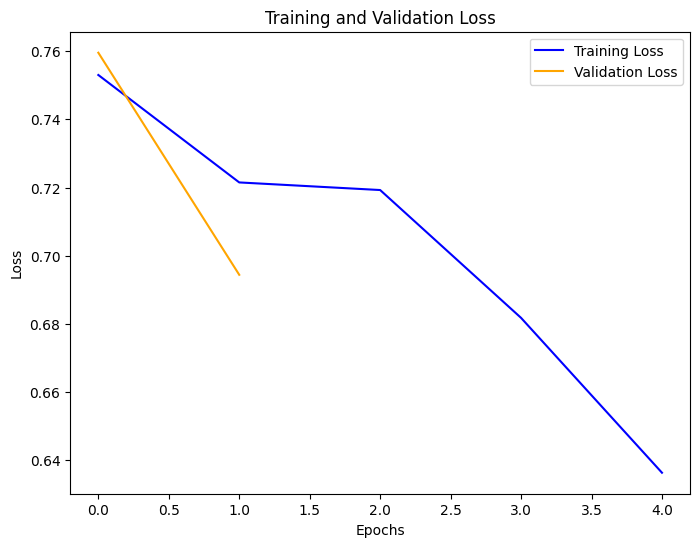

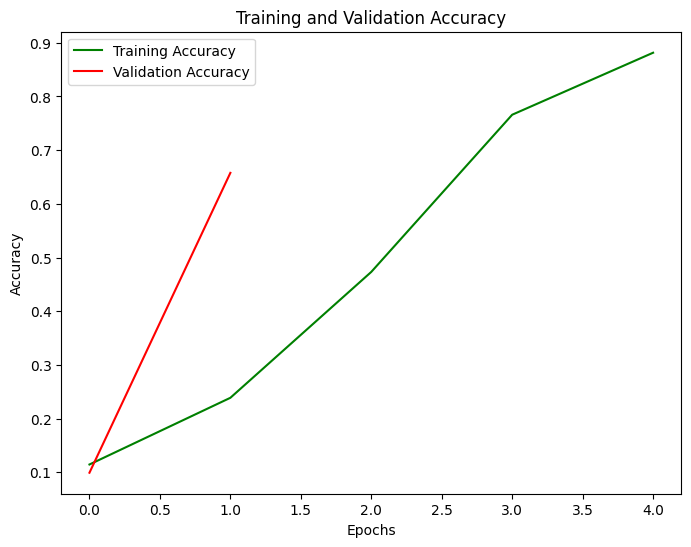

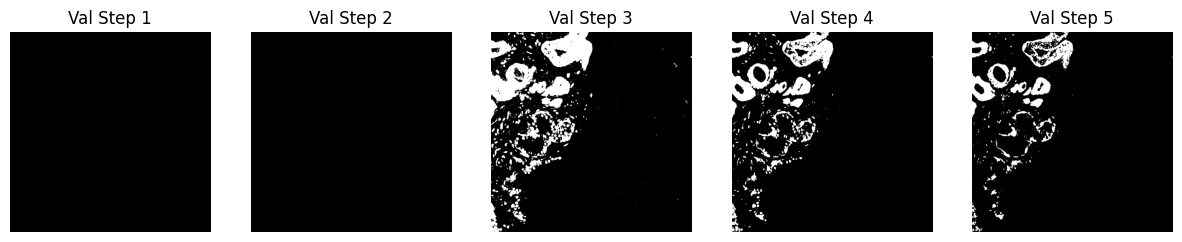

In [26]:
# Create your loss and accuracy graphs, and print out the 5 validation images:
# We do not expect this network to have learned well.
# Plot training and validation losses
plot_losses(train_losses, val_losses)

# Plot training and validation accuracies
plot_accuracies(train_accs, val_accs)

# Plot the 5 predictions of val_x
plot_predictions(val_images, titles=["Val Step 1", "Val Step 2", "Val Step 3", "Val Step 4", "Val Step 5"])

In [27]:
# Delete objects to free GPU memory
del small_net, small_optimizer, train_losses, train_accs, val_losses, val_accs, val_images

# Also, clear cached memory to ensure all unused memory is freed
torch.cuda.empty_cache()

---

# Part 4: Implementing the UNet

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf)

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)
<!-- <img src="https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400" width="1600" height="1200"/> -->

You will implement the UNet with some simplifying adjustments.
The original UNet does not pad their convolutions, so their output is smaller than their input.
Your input and output are the same size so you should pad your convolutions.
The only time height and width should change are from "max pool" and the "up-conv".
This means you no longer need to "crop" the cross connections, since both sides of the U should have the same spatial dimensions.

This is a large complex network structure and due to the cross connections, you can't just stick a bunch of layers into `nn.Sequential`.
This network does have a clear repeating pattern of blocks that move down (left side of U) and blocks that move up (right side of U).
Just like how we use functions to made our code more modular, we'll create two modules to capture that repeating structure to simplify our final network.

Implement `DownBlock` (left side of U): The `DownBlock` incorporates 2 sequential convolution layers (with nonlinearities) followed by a downsampling (`nn.MaxPool2d`).
It should return the downsampled image and the cross connection output.
You should NOT use `copy` or `clone` on the cross connection output to do the "copy and crop" operation; just return the same tensor you passed into `MaxPool2D` layer.

In [28]:
# You are welcome (and encouraged) to use the built-in batch normalization, nn.BatchNorm2d, and dropout layers, nn.Dropout.

class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()

        # Define two convolutional layers with padding to keep the size consistent
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Batch normalization and dropout layers for regularization
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.3)

        # Max pooling layer for downsampling
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # First convolution block with batchnorm, activation, and dropout
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        # Second convolution block with batchnorm and activation
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = torch.relu(x)

        # Cross connection output
        cross_connection = x

        # Downsample the image
        x = self.maxpool(x)

        return x, cross_connection

Implement `UpBlock` (right side of U): The `UpBlock` incorporates an upsampling (i.e. `nn.Conv2DTranspose`) followed by 2 sequential convolution layers (with nonlinearities). Its input should be a downsampled image, `x`, and the cross connection output, `cross_output`, from a `DownBlock`.

In [29]:
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(UpBlock, self).__init__()

        # Up-convolution to upsample the feature map
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # After concatenation, the number of channels is doubled
        self.conv1 = nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        # Batch normalization and dropout layers
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, cross_output):
        # Upsample the input feature map
        x = self.upconv(x)

        # Concatenate with the corresponding feature map from the downsampling path
        x = torch.cat([x, cross_output], dim=1)

        # First convolution block
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = torch.relu(x)
        x = self.dropout(x)

        # Second convolution block
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = torch.relu(x)

        return x

Test below that your `DownBlock` and `UpBlock` work correctly.
Create a function `test_updown_block()` which instantiates a `DownBlock` and `UpBlock` and passes in a dummy image `x = torch.zeros((2, 4, 16, 16))`.
You want to make sure that the output of your `UpBlock` and the cross-connection output of your `DownBlock`'s have the shape of `(2, 8, 16, 16)`.
Remember to use `torch.no_grad()`.

In [30]:
def test_updown_block():
    import torch
    import torch.nn as nn

    # Instantiate the DownBlock and UpBlock
    down_block = DownBlock(in_channels=4, out_channels=8)
    up_block = UpBlock(in_channels=8, out_channels=8)

    # Create a dummy input tensor
    x = torch.zeros((2, 4, 16, 16))

    with torch.no_grad():
        # Pass the input through the DownBlock
        x_downsampled, cross_output = down_block(x)

        # Pass the downsampled output and cross connection through the UpBlock
        up_output = up_block(x_downsampled, cross_output)

        # Check the shapes of the outputs
        print("Shape of cross_output from DownBlock:", cross_output.shape)
        print("Expected shape: (2, 8, 16, 16)")
        print("Shape of output from UpBlock:", up_output.shape)
        print("Expected shape: (2, 8, 16, 16)")

Implement the `UNet` using your `UpBlock` and `DownBlock` modules.
You will additionally need to add layers for the bottom of the U and the final output layer.
You do not need to use the same number of channels as the UNet paper. It is recommended you use fewer channels for faster training and less memory consumption. `[8, 16, 32, 64]` are a good choice for channel sizes.

*Note: If you want to store `UpBlock`s and `DownBlock`s in a list then use the `nn.ModuleList()` which is a module that operates like a list, but exposes the modules to PyTorch.*

In [31]:
class UNet(nn.Module):
    def __init__(self, channels=(8, 16, 32, 64), num_classes=1):
        super(UNet, self).__init__()

        # Encoder (Downsampling path)
        self.down_blocks = nn.ModuleList()
        in_channels = 3  # Assuming input has 3 channels (e.g., RGB image)
        for out_channels in channels:
            self.down_blocks.append(DownBlock(in_channels, out_channels))
            in_channels = out_channels  # Update in_channels for the next DownBlock

        # Bottleneck (Bottom of the U)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(channels[-1], channels[-1] * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels[-1] * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(channels[-1] * 2, channels[-1] * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels[-1] * 2),
            nn.ReLU(inplace=True),
        )

        # Decoder (Upsampling path)
        self.up_blocks = nn.ModuleList()
        in_channels = channels[-1] * 2  # Starting from the bottleneck's output channels
        reversed_channels = list(reversed(channels))
        for out_channels in reversed_channels:
            self.up_blocks.append(UpBlock(in_channels, out_channels))
            in_channels = out_channels  # Update in_channels for the next UpBlock

        # Final output layer
        self.final_conv = nn.Conv2d(channels[0], num_classes, kernel_size=1)

    def forward(self, x):
        cross_connections = []

        # Encoder path (DownBlocks)
        for down_block in self.down_blocks:
            x, cross = down_block(x)
            cross_connections.append(cross)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path (UpBlocks)
        for idx, up_block in enumerate(self.up_blocks):
            # Retrieve the corresponding cross-connection from the encoder
            cross = cross_connections[-(idx + 1)]
            x = up_block(x, cross)

        # Final output layer
        output = self.final_conv(x)
        return output

Test `UNet` by making sure that it takes a batch of input images `x` and returns an appropriately-shaped output.

In [32]:
def test_UNet_shapes():
    import torch
    import torch.nn as nn

    # Instantiate the UNet model
    model = UNet(in_channels=3, channels=(8, 16, 32, 64), num_classes=1)

    # Create a dummy input tensor
    # For example, batch size of 2, 3-channel images of size 128x128
    x = torch.zeros((2, 3, 128, 128))

    with torch.no_grad():
        # Pass the input through the model
        output = model(x)

        # Check the shape of the output
        print("Input shape:", x.shape)
        print("Output shape:", output.shape)
        print("Expected output shape: (2, 1, 128, 128)")

---

# Training and Testing UNet

Train `UNet` below and get a better than baseline accuracy. For Colab/Kaggle users, we recommend training with a small `UNet` first on the CPU and then scaling up the `UNet` and training on the GPU.

In [33]:
# Hyperparameters
n_minibatch_steps = 1000 # number of optimization steps
train_log_interval = 10 # how many steps between saving training loss and accuracy
val_interval = 200 # how many steps between performing the validation loop
val_im_delay = 50 # how many steps before we start storing validation image predictions

# Create the model, define loss function and optimizer
model = UNet().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Initialize statistics storage
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

step = 0

# Training loop
while step < n_minibatch_steps:
    model.train()
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = targets.unsqueeze(1)  # Add channel dimension

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        preds = torch.sigmoid(outputs) > 0.5
        correct = (preds == targets).float().mean()

        if step % train_log_interval == 0:
            train_losses.append(loss.item())
            train_accuracies.append(correct.item())
            print(f"Step {step}, Loss: {loss.item():.4f}, Accuracy: {correct.item():.4f}")

        if step % val_interval == 0:
            model.eval()
            val_loss_total = 0
            val_correct_total = 0
            with torch.no_grad():
                for val_batch in val_loader:
                    val_inputs, val_targets = val_batch
                    val_inputs = val_inputs.to(device)
                    val_targets = val_targets.to(device)
                    val_targets = val_targets.unsqueeze(1)  # Add channel dimension

                    val_outputs = model(val_inputs)
                    val_loss = loss_fn(val_outputs, val_targets)
                    val_loss_total += val_loss.item()

                    val_preds = torch.sigmoid(val_outputs) > 0.5
                    val_correct = (val_preds == val_targets).float().mean()
                    val_correct_total += val_correct.item()

            val_loss_avg = val_loss_total / len(val_loader)
            val_acc_avg = val_correct_total / len(val_loader)
            val_losses.append(val_loss_avg)
            val_accuracies.append(val_acc_avg)
            print(f"Validation Loss: {val_loss_avg:.4f}, Validation Accuracy: {val_acc_avg:.4f}")

        step += 1
        if step >= n_minibatch_steps:
            break

Step 0, Loss: 0.7043, Accuracy: 0.4782
Validation Loss: 0.7299, Validation Accuracy: 0.0993
Step 10, Loss: 0.7183, Accuracy: 0.0075
Step 20, Loss: 0.6826, Accuracy: 0.7844
Step 30, Loss: 0.3406, Accuracy: 0.9342
Step 40, Loss: 0.4369, Accuracy: 0.9137
Step 50, Loss: 0.6883, Accuracy: 0.6347
Step 60, Loss: 0.8446, Accuracy: 0.5476
Step 70, Loss: 0.2224, Accuracy: 0.9907
Step 80, Loss: 0.4019, Accuracy: 0.8683
Step 90, Loss: 0.1626, Accuracy: 1.0000
Step 100, Loss: 0.2262, Accuracy: 0.9483
Step 110, Loss: 0.1745, Accuracy: 1.0000
Step 120, Loss: 0.3642, Accuracy: 0.8546
Step 130, Loss: 0.1707, Accuracy: 0.9744
Step 140, Loss: 0.2352, Accuracy: 0.9367
Step 150, Loss: 0.1795, Accuracy: 0.9805
Step 160, Loss: 0.2802, Accuracy: 0.9112
Step 170, Loss: 0.1890, Accuracy: 0.9610
Step 180, Loss: 0.3478, Accuracy: 0.8928
Step 190, Loss: 0.1505, Accuracy: 0.9596
Step 200, Loss: 0.4671, Accuracy: 0.8061
Validation Loss: 0.2868, Validation Accuracy: 0.9028
Step 210, Loss: 0.0720, Accuracy: 0.9837
Ste

Plot your training/validation losses and accuracies.

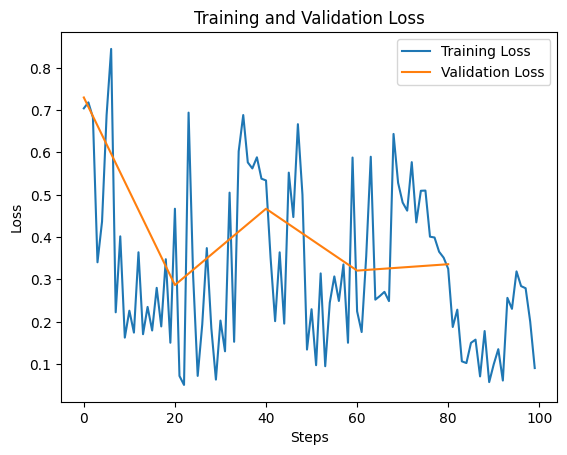

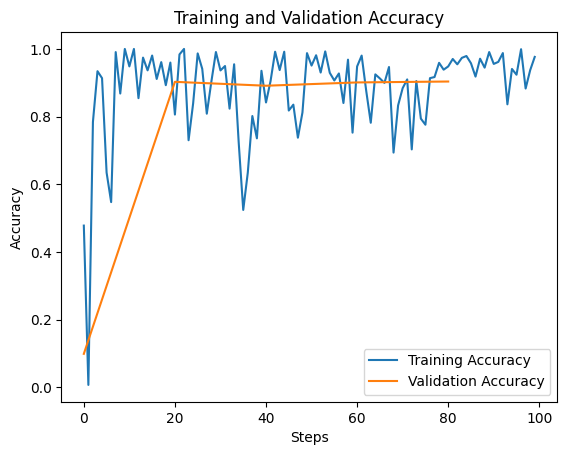

In [34]:
# Plot training and validation losses and accuracies
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Training Loss')
plt.plot(range(0, len(train_losses), val_interval // train_log_interval), val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(range(0, len(train_accuracies), val_interval // train_log_interval), val_accuracies, label='Validation Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

Visualize the 5 predictions of `val_x`. Your images should start to look like the `plot_cancer()` image you made above (signs of cancer in the top left corner).

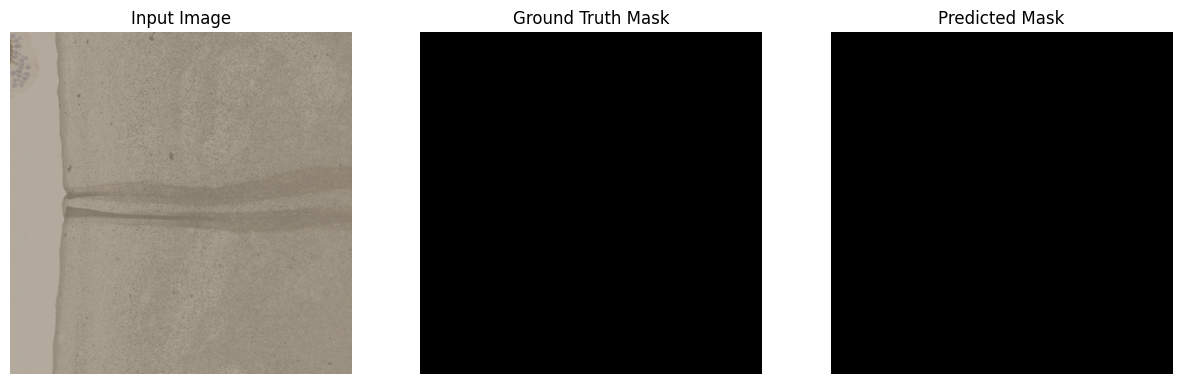

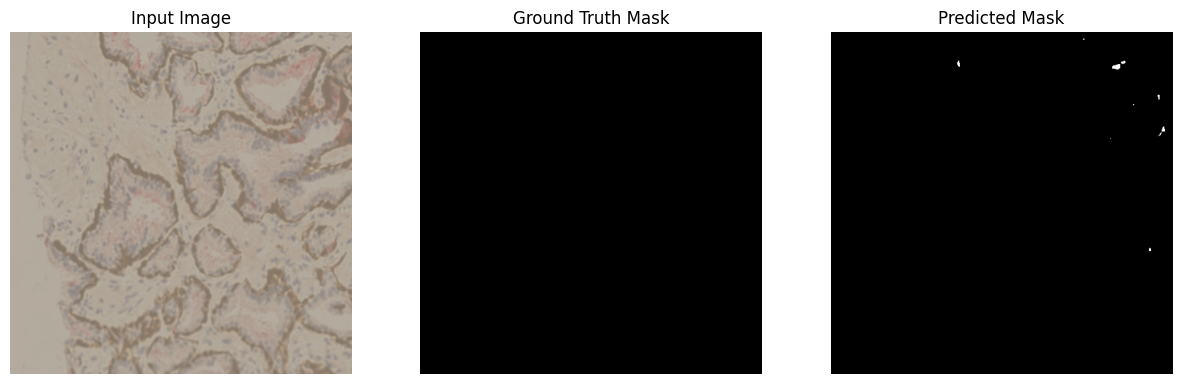

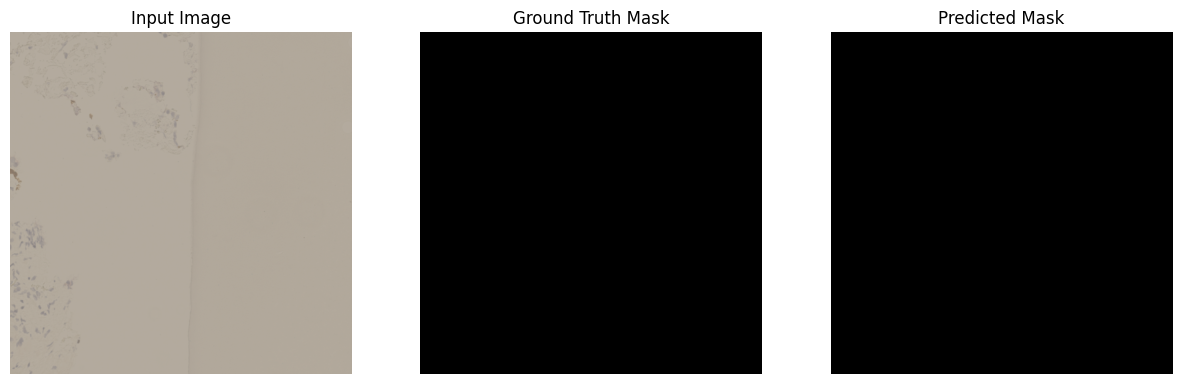

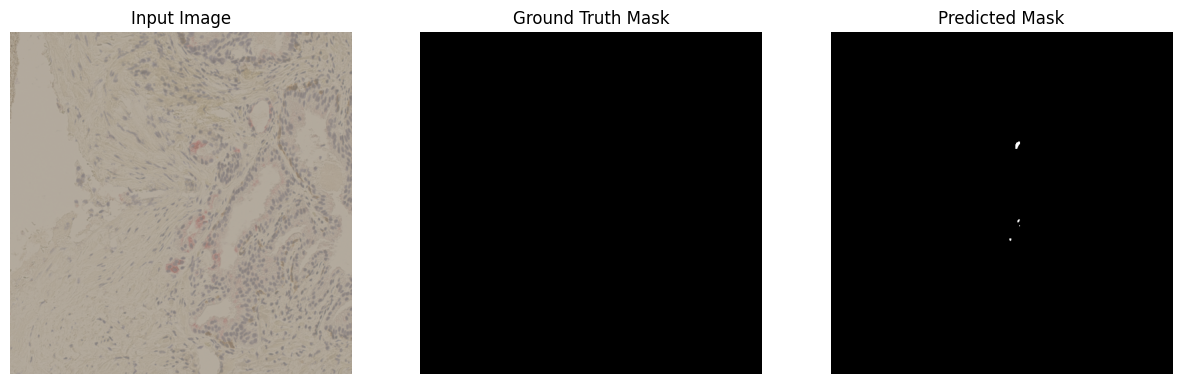

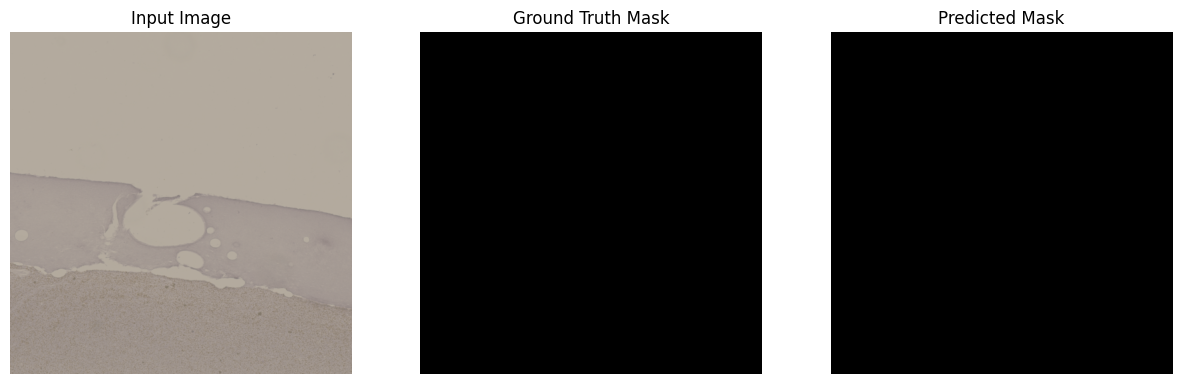

In [35]:
# Ensure the model is in evaluation mode
model.eval()

# Number of samples to visualize
num_samples = 5

# Function to denormalize images if normalization was applied during preprocessing
def denormalize(image_tensor, mean, std):
    mean = torch.tensor(mean).reshape(1, -1, 1, 1)
    std = torch.tensor(std).reshape(1, -1, 1, 1)
    image_tensor = image_tensor * std + mean
    return image_tensor

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Lists to store inputs, targets, and predictions
inputs_list = []
targets_list = []
preds_list = []

# Get validation data from val_loader
with torch.no_grad():
    val_iter = iter(val_loader)
    samples_collected = 0

    while samples_collected < num_samples:
        try:
            inputs, targets = next(val_iter)
        except StopIteration:
            # Re-initialize the iterator if we've exhausted the DataLoader
            val_iter = iter(val_loader)
            inputs, targets = next(val_iter)

        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) > 0.5

        # Process each sample in the batch
        batch_size = inputs.size(0)
        for i in range(batch_size):
            # Collect inputs, targets, and predictions
            inputs_list.append(inputs[i].cpu())
            targets_list.append(targets[i].cpu())
            preds_list.append(preds[i].cpu())
            samples_collected += 1
            if samples_collected >= num_samples:
                break

# Visualization
for i in range(num_samples):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Get the i-th sample
    input_img = inputs_list[i]  # [C, H, W]
    target_msk = targets_list[i]  # [H, W] or [1, H, W]
    pred_msk = preds_list[i]  # [H, W] or [1, H, W]

    # Denormalize input image if it was normalized
    input_img = denormalize(input_img.unsqueeze(0), mean, std).squeeze(0)
    input_img = torch.clamp(input_img, 0, 1)  # Ensure pixel values are between 0 and 1

    # Squeeze target and prediction masks if necessary
    if target_msk.dim() == 3 and target_msk.size(0) == 1:
        target_msk = target_msk.squeeze(0)
    if pred_msk.dim() == 3 and pred_msk.size(0) == 1:
        pred_msk = pred_msk.squeeze(0)

    # Input Image
    axs[0].imshow(input_img.permute(1, 2, 0))
    axs[0].set_title('Input Image')
    axs[0].axis('off')

    # Ground Truth Mask
    axs[1].imshow(target_msk, cmap='gray')
    axs[1].set_title('Ground Truth Mask')
    axs[1].axis('off')

    # Predicted Mask
    axs[2].imshow(pred_msk, cmap='gray')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')

    plt.show()